# Implementation of Variational AutoEncoder (VAE)

     

In [ ]:
!pip install torch torchvision numpy tqdm

In [ ]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [ ]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 135441210.71it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39278759.35it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 206327497.74it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5164144.42it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



### Step 2. Define our model: Variational AutoEncoder (VAE)

In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x) # x is raw input, my encoder takes x and gives mu and sigma which are functions of x.
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward() # loss minimization
        optimizer.step() # weight update

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  174.6489016035841
	Epoch 2 complete! 	Average Loss:  130.6761777115505
	Epoch 3 complete! 	Average Loss:  116.57954545009912
	Epoch 4 complete! 	Average Loss:  112.39075456163918
	Epoch 5 complete! 	Average Loss:  110.05195048387938
	Epoch 6 complete! 	Average Loss:  108.4236922377139
	Epoch 7 complete! 	Average Loss:  107.25507008751565
	Epoch 8 complete! 	Average Loss:  106.2865957259495
	Epoch 9 complete! 	Average Loss:  105.5827692638773
	Epoch 10 complete! 	Average Loss:  104.90630955563961
	Epoch 11 complete! 	Average Loss:  104.29388554491861
	Epoch 12 complete! 	Average Loss:  103.88038374504383
	Epoch 13 complete! 	Average Loss:  103.4285074081803
	Epoch 14 complete! 	Average Loss:  103.19627668836081
	Epoch 15 complete! 	Average Loss:  102.86415497182804
	Epoch 16 complete! 	Average Loss:  102.61125088037353
	Epoch 17 complete! 	Average Loss:  102.2876402891538
	Epoch 18 complete! 	Average Loss:  102.125216522981
	Epoch

### Step 5. Generate images from test dataset

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

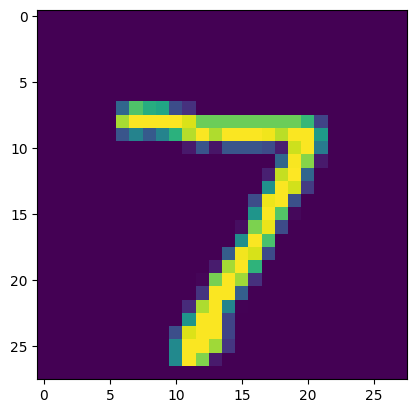

In [ ]:
show_image(x, idx=0)

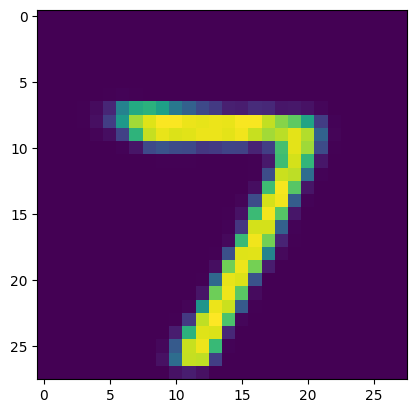

In [ ]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [ ]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

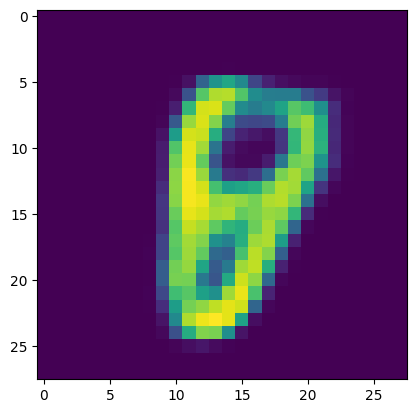

In [ ]:
show_image(generated_images, idx=12)

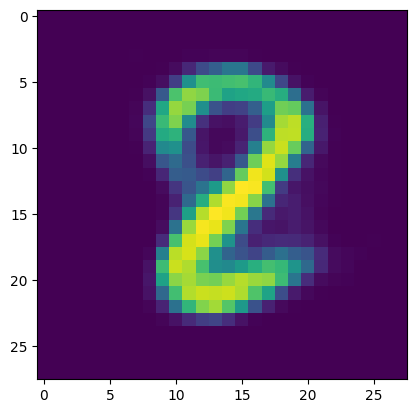

In [ ]:
show_image(generated_images, idx=0)

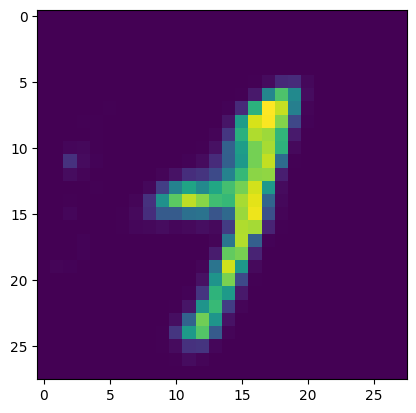

In [ ]:
show_image(generated_images, idx=1)

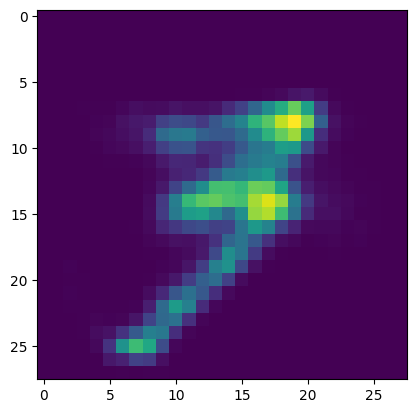

In [ ]:
show_image(generated_images, idx=10)

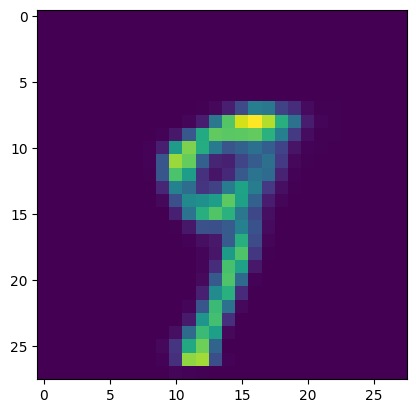

In [ ]:
show_image(generated_images, idx=20)

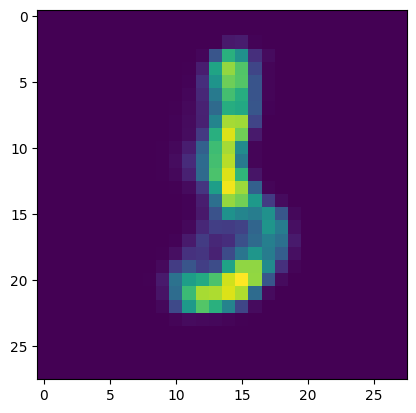

In [ ]:
show_image(generated_images, idx=50)

In [ ]:
x = torch.tensor([1.0])

In [ ]:
type(x.item())

float

In [ ]:
type(x.squeeze())

torch.Tensor

In [ ]:
y = x.squeeze()


In [ ]:
y

tensor(1.)

In [ ]:
0.5 + y

tensor(1.5000)

In [ ]:
x.shape

torch.Size([1])

In [ ]:
x.squeeze().shape

torch.Size([])